In [1]:
from matplotlib import pyplot as plt
import torch
from torch.utils.data import TensorDataset,DataLoader
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import load_iris
import warnings
import time
import seaborn
from torch import nn
from typing import Optional,Union
from torchvision import transforms

### 搭建Inception块
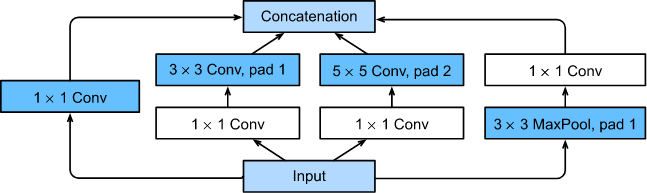

In [7]:
class Inception(nn.Module):
    def __init__(self, c1:int, c2:Union[list,tuple], c3:Union[list,tuple], c4:int) -> None:
        """_summary_

        Args:
            c0 (int)
            c1 (Optional[list])
            c2 (Optional[list])
            c3 (int)
            represent out_channels of each branch
        """        
        super().__init__()
        
        self.branch1 = nn.Sequential(nn.LazyConv2d(out_channels=c1, kernel_size=1),
            nn.ReLU()
        )
        self.branch2 = nn.Sequential(
            nn.LazyConv2d(out_channels=c2[0], kernel_size=1),
            nn.LazyConv2d(out_channels=c2[1], kernel_size=3,padding=1), # 保持输入输出的图像尺寸不变
            nn.ReLU()
        )
        self.branch3 = nn.Sequential(
            nn.LazyConv2d(out_channels=c3[0], kernel_size=1),
            nn.LazyConv2d(out_channels=c3[1], kernel_size=5,padding=2),
            nn.ReLU()
        )
        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3,padding=1,stride=1),
            nn.LazyConv2d(out_channels=c4, kernel_size=3,padding=1)
        )
        
    def forward(self, X:torch.Tensor)->torch.Tensor:
        res1 = self.branch1(X)  # torch.Size(example,c0,height,width)
        res2 = self.branch2(X)  # torch.Size(example,c1[1],height,width)
        res3 = self.branch3(X)  # torch.Size(example,c2[1],height,width)
        res4 = self.branch4(X)  # torch.Size(example,c3,height,width)
        # 将各个branch的通道维度压扁融合
        return torch.cat([res1,res2,res3,res4], dim=1) # torch.Size(example, c0 + c1[1] + c2[1] + c3, height, width)
    
    

# input dimension 192 output dimension 256 = 64 + 128 + 32 + 32 (2:4:1:1)
# 为什么要输出通道要如下设置: 96的来源--96对应于上述该branch最终提供通道数/所有branch提供通道数(branch2 channel/all branch channel) * input channel
#           ||____________
#           |___________  |
# test                  | |
# model = Inception(64,[96,128],[16,32],32)
# model.forward(torch.rand(2,3,224,224)).shape # (2,256,224,224)


In [3]:
torch.cat([i for i in torch.rand(3,3,3,5,5)],dim=1).shape

torch.Size([3, 9, 5, 5])

### 搭建GoogleNet
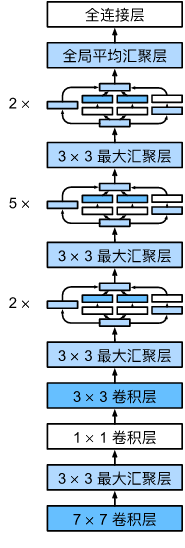

In [11]:
# 不完全按照上图，上图的网络对于个人太大了，起到学习作用即可
def init_normal(m):
    nn.init.normal_(m.weight, mean=0, std=0.01)
    nn.init.zeros_(m.bias)

class GoogleNet(object):
    def __init__(self, num_classes:int) -> None:
        self.block1 = nn.Sequential(
        nn.LazyConv2d(out_channels=64, kernel_size=7, stride=2,padding=3),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=3, padding=1, stride=2)
        )
        self.block2 = nn.Sequential(
            nn.LazyConv2d(64, kernel_size=1), nn.ReLU(),
            nn.LazyConv2d(192, kernel_size=3,padding=1), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3,padding=1, stride=2)
        )
        self.block3 = nn.Sequential(
            Inception(64, (96, 128), (16, 32), 32),
            Inception(128, (128, 192), (32, 96), 64),
            nn.AdaptiveAvgPool2d((1,1)), nn.Flatten()
        )
        # block3 result size(example, 480*6*6)
        self.net = nn.Sequential(self.block1, self.block2, self.block3, nn.LazyLinear(num_classes))
        # self.net.apply(init_normal)
    
model = GoogleNet(10)

model.net(torch.rand(1,1,96,96)).shape

torch.Size([1, 10])